집단별 어떤 브랜드, 카테고리 제품의 푸시 알림을 보내는게 좋을까?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# "rfm.csv" 읽고 CustomerID 인덱스로 지정하기
df = pd.read_parquet('rfm.parquet.gzip')
df.shape

(18684, 9)

In [5]:
# Recency, Frequency, MonetaryValue 만 따로 rfm_cluster 변수에 담아 사용하기
rfm_cluster = df[['Recency', 'Frequency', 'MonetaryValue']]
print(rfm_cluster.shape)
rfm_cluster

(18684, 3)


,Recency,Frequency,MonetaryValue
user_id,,,
435648894,26,1,388.130005
437371552,30,1,179.139999
450756413,29,1,43.730000
456810531,7,1,133.350006
473668240,23,1,149.039993
...,...,...,...
566188229,1,1,221.339996
566210490,1,1,514.780029
566227458,1,1,465.910004


In [6]:
rfm_cluster.describe()

,Recency,Frequency,MonetaryValue
count,18684.000000,18684.000000,18684.000000
mean,15.103725,1.101263,409.069336
std,9.348765,0.431114,487.437958
min,1.000000,1.000000,2.450000
25%,7.000000,1.000000,131.529999
50%,13.000000,1.000000,243.470001
75%,24.000000,1.000000,506.282501
max,31.000000,12.000000,15507.000000


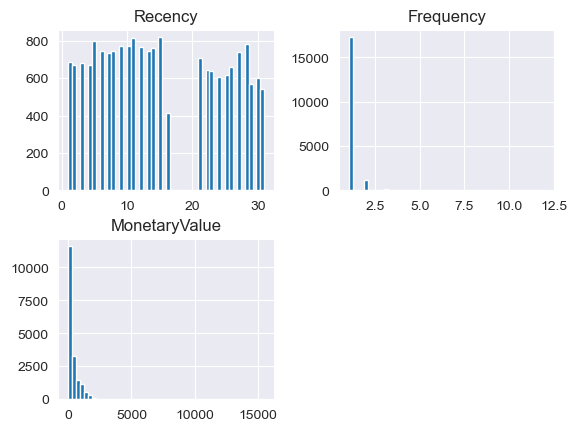

In [7]:
rfm_cluster.hist(bins=50);

In [8]:
# log 변환
# 회귀나 k-means에서 log 변환 시 성능이 조금 더 좋아짐

rfm_cluster_log = np.log(rfm_cluster + 1)
rfm_cluster_log.head()

,Recency,Frequency,MonetaryValue
user_id,,,
435648894,3.295837,0.693147,5.963913
437371552,3.433987,0.693147,5.193734
450756413,3.401197,0.693147,3.800644
456810531,2.079442,0.693147,4.900448
473668240,3.178054,0.693147,5.010902


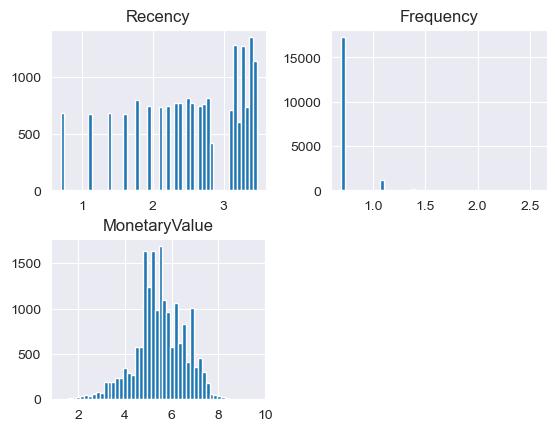

In [9]:
rfm_cluster_log.hist(bins=50);

In [10]:
rfm_cluster_log.describe()

,Recency,Frequency,MonetaryValue
count,18684.000000,18684.000000,18684.000000
mean,2.551565,0.730160,5.501298
std,0.745280,0.140117,1.062550
min,0.693147,0.693147,1.238374
25%,2.079442,0.693147,4.886809
50%,2.639057,0.693147,5.499093
75%,3.218876,0.693147,6.229068
max,3.465736,2.564949,9.649112


## 스케일링

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()
X = scaler.fit_transform(rfm_cluster_log)
X

array([[ 0.99867391, -0.26416645,  0.43539276],
       [ 1.18404587, -0.26416645, -0.2894654 ],
       [ 1.14004805, -0.26416645, -1.60057897],
       ...,
       [-2.49364962, -0.26416645,  0.60689317],
       [-2.49364962, -0.26416645,  1.80187248],
       [-2.49364962, -0.26416645,  1.01645356]])

In [12]:
# 데이터 프레임으로 저장
pd.DataFrame(X).describe().round(2)

,0,1,2
count,18684.00,18684.00,18684.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.49,-0.26,-4.01
25%,-0.63,-0.26,-0.58
50%,0.12,-0.26,-0.00
75%,0.90,-0.26,0.68
max,1.23,13.10,3.90


## KMeans

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

inertia = [] # 같은 애들끼리 얼마나 똘똘 뭉쳐있는지
silhouettes = []
range_n_clusters = range(2, 20)

for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels=kmeans.labels_))
    print(n_cluster, end=',')

2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

## Elbow Method

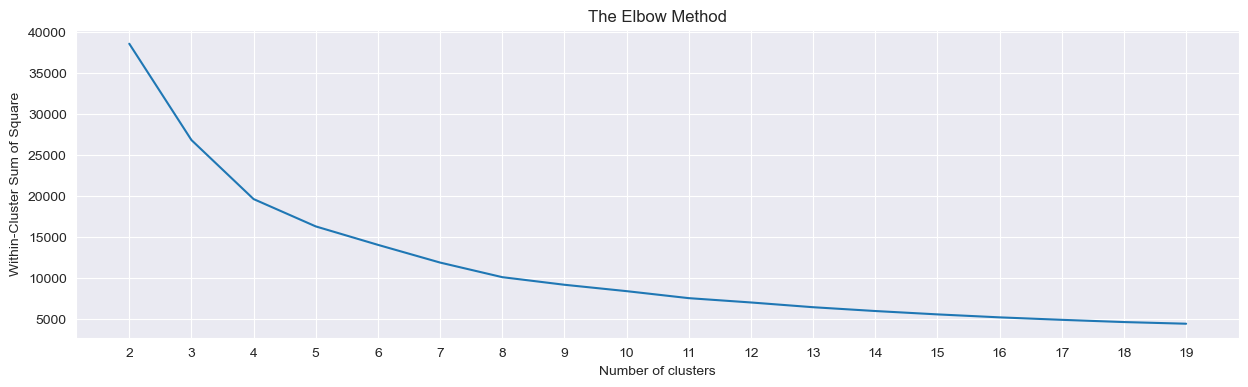

In [15]:
plt.figure(figsize=(15,4))
plt.plot(range_n_clusters, inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.xticks(range_n_clusters)
plt.show()

## Silhouette Score

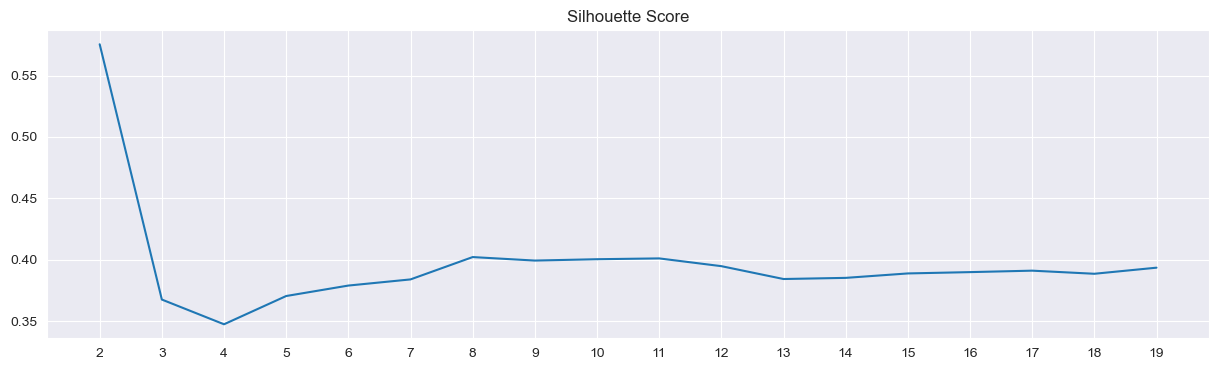

In [16]:
plt.figure(figsize=(15, 4))
plt.title('Silhouette Score')
plt.plot(range_n_clusters, silhouettes)
plt.xticks(range_n_clusters)
plt.show()

## KElbowVisualizer

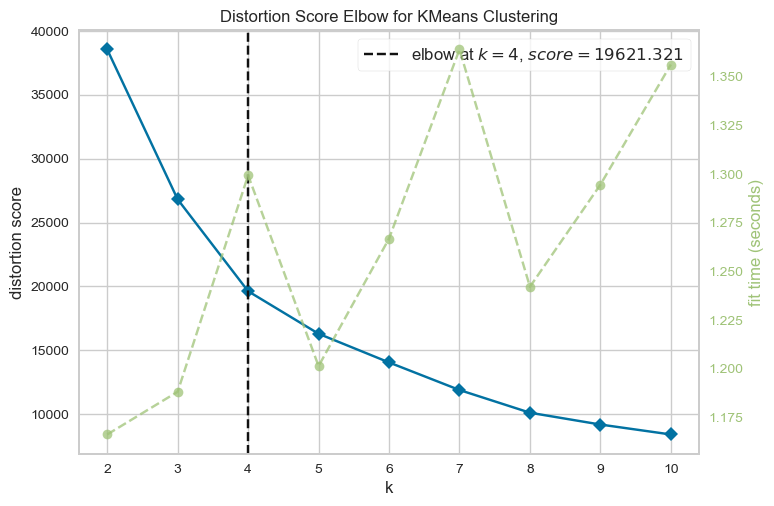

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# yellowbrick.cluster 에서 KElbowVisualizer 불러오기
from yellowbrick.cluster import KElbowVisualizer

KEV = KElbowVisualizer(kmeans, k=10, n_init="auto")
KEV.fit(X)
KEV.show()

## 분석한 내용을 바탕으로 KMeans n_clusters 값을 정해 학습하기

In [29]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [30]:
kmeans.labels_

array([3, 1, 1, ..., 0, 0, 0])

In [31]:
pd.Series(kmeans.labels_).value_counts()

3    6356
1    6355
0    4571
2    1402
dtype: int64

In [32]:
# silhouette_score 구하기
silhouette_avg = silhouette_score(X, kmeans.labels_)
silhouette_avg

0.3474821060800943

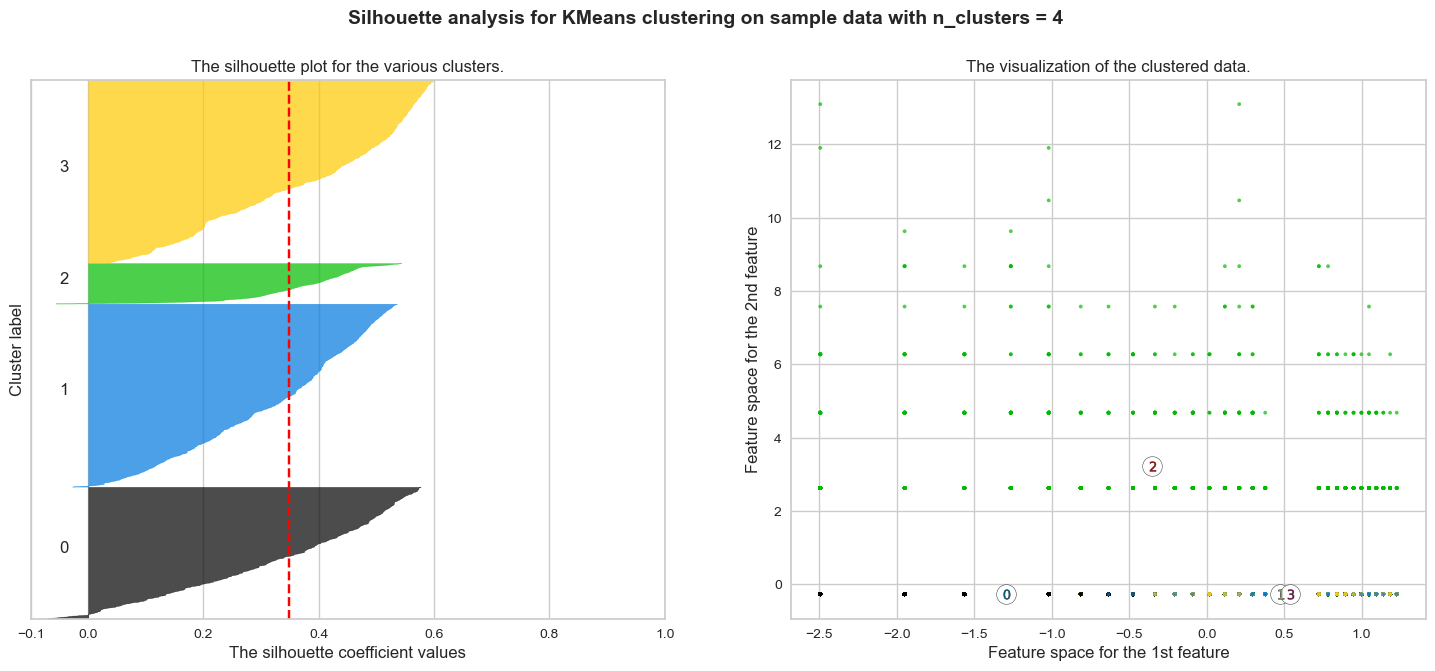

In [33]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
cluster_labels = kmeans.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [34]:
df['Cluster'] = kmeans.labels_
df.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7,silver,3
437371552,30,1,179.139999,1,1,2,112,4,silver,1
450756413,29,1,43.730000,1,1,1,111,3,silver,1
456810531,7,1,133.350006,4,1,2,412,7,silver,0
473668240,23,1,149.039993,2,1,2,212,5,silver,1


In [35]:
# class를 qcut으로 구한거랑 머신러닝으로 구한 것 비교
pd.crosstab(df['RFM_class'], df['Cluster'])

Cluster,0,1,2,3
RFM_class,,,,
silver,649,5233,25,2459
gold,1363,958,108,2441
platinum,2559,164,1269,1456
